# Analyzing Evolving Job Requirements Using Machine Learning
Author: Matthew Huh


## Overview

Connecting people with prospective employers is quite a daunting task as it's very difficult to accurately gauge the supply and demand of positions over time. Employers may want to add or remove certain skillsets, and in order for people to find employment, they'll have to adjust their skillsets to accomodate those that employers are looking for. The component that this project will address is determining what skillsets employers are looking for in the broad realm of data science.

## About the Data

The data used for this capstone project has been obtained from Indeed, a job board that contains thousands of new listings every day and should provide an up-to-date collection of postings that we'll examine. The data that will be extracted are the job's 
* title
* location
* company
* salary
* synopsis
* query

Associated web scraper script can be found at 
https://github.com/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Indeed%20Job%20Scraper.ipynb

## Research Question

The bulk of the analysis will be conducted by examining the synopsis of each posting, and determine what keywords we can identify with each query. Since this is for a data science course, the queries that I chose to examine are positions tha should be a good fit for the contents of this course, namely

* data analyst
* data scientist
* data engineer

## Packages

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Import the dataframe
job_data = pd.read_csv('data/job_board.csv', index_col=False)
job_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
job_data.shape

(671, 7)

In [4]:
# Preview the data
job_data.head(10)

,Title,Location,Company,Salary,Synopsis,Query,Metro
0,Data Analyst,"Duluth, MN",Members Cooperative Credit Union,None,The Data Analyst i...,data+analyst,united states
1,Data Analyst,"Elgin, IL",voestalpine High Performance Metals Co...,None,Proven work experi...,data+analyst,united states
2,Data Analyst,"Jersey City, NJ 07311 (Downtown area)",Tradeweb Markets LLC,None,Tradeweb has an op...,data+analyst,united states
3,Web Data Analyst,"Pleasant Prairie, WI 53158",Uline,None,Web Data Analyst. ...,data+analyst,united states
4,SAS Programmer (Data Analyst),"Washington, DC","Oasis Systems, Inc.",None,Perform data proce...,data+analyst,united states
5,CLINICAL SYSTEM DATA ANALYST (STATISTICAL PROG...,"Philadelphia, PA 19102 (City Center West area)",Temple Health,None,Provides clinical ...,data+analyst,united states
6,Junior Data Analyst,"Valhalla, NY",Rectangle Health,None,Data visualization skills (ex. As the Junior D...,data+analyst,united states
7,Business / Data Analyst,"New York, NY 10038 (Financial District area)",Bank of America,None,"Proficient with Data modeling, SQL...",data+analyst,united states
8,Data Analyst,"New York, NY 10005 (Financial District area)",Murmuration,None,The Data Analyst will:. The Data A...,data+analyst,united states
9,Jr. Data Analyst (Data Assurance) ~ Entry Level,"Jersey City, NJ",Genuent,\r\n $20 - $25 an hour,"Data Analyst (Data Assurance) ~ Jersey City, N...",data+analyst,united states


In [5]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       189
Location    155
Company     338
Salary       76
Synopsis    635
Query         3
Metro         1
dtype: int64

In [7]:
# # View all job titles (Not that useful since there are a LOT)
# plt.rcParams['figure.figsize'] = [20,5]
# plt.xticks(rotation=70)
# plt.title('Title Frequency')

# sns.barplot(job_data['Title'].unique(), job_data['Title'].value_counts(), data=job_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
job_data['Title'].value_counts()

Data Scientist                                                     119
Data Analyst                                                       104
Data Engineer                                                       75
Junior Data Scientist                                               13
Big Data Engineer                                                    7
Junior Data Analyst                                                  7
Data Entry Analyst                                                   5
Entry Level Business Analyst                                         5
Data Analyst (Entry Level)                                           5
Product Data Analyst                                                 5
Data Analyst Intern                                                  5
Junior Data Engineer                                                 4
Data Scientist / Predictive Modeler                                  4
Associate Data Scientist                                             4
Lookin

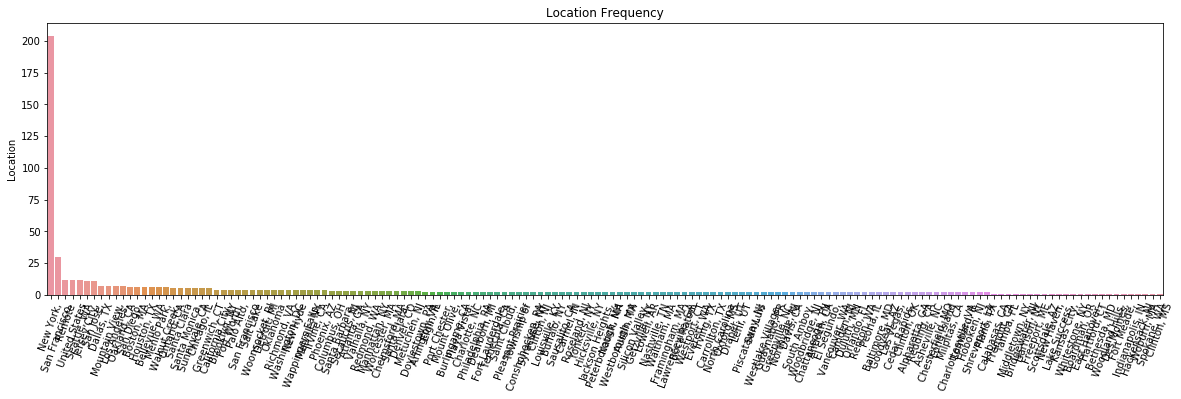

In [9]:
# Plot occurences of each location
# (Not used for anything yet, idk if I'll keep it)
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')
x = job_data['Location'].value_counts().index.tolist()
y = job_data['Location'].value_counts()

sns.barplot(x, y, data=job_data)

In [10]:
# Create series with location count
# (Not used for anything yet, idk if I'll keep it)
location_data = job_data['Location'].value_counts()
location_data

New York,              204
San Francisco,          30
Remote                  12
United States           12
Seattle, WA             12
Jersey City,            11
San Jose,               11
Dallas, TX               7
Mountain View,           7
Los Angeles,             7
Oakland, CA              7
San Diego,               6
Boston, MA               6
Houston, TX              6
Bellevue, WA             6
Menlo Park,              6
Walnut Creek,            6
Ontario, CA              5
Santa Clara              5
Santa Monica,            5
Sunnyvale, CA            5
Chicago, IL              5
Greenwich, CT            5
California City,         4
Brooklyn, NY             4
Fort Worth,              4
Palo Alto,               4
San Francisco            4
Salt Lake                4
Woonsocket, RI           4
                      ... 
Milpitas, CA             2
Charlottesville, VA      2
Lombard, IL              2
Hoboken, NJ              2
Shreveport, LA           2
Plano, TX                2
C

In [11]:
# Attempt at creating a bubble map using geopandas / plotly
# Step 1: get geopandas to import
# Step 2: create geodataframe with city, lat, long
# Step 3: Plotly

# import geopandas
# import geolocator

# location = geolocator.geocode('New York')
# print(location.latitude)

# layout = dict(
#         title = '2014 US city populations<br>(Click legend to toggle traces)',
#         showlegend = True,
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showland = True,
#             landcolor = 'rgb(217, 217, 217)',
#             subunitwidth=1,
#             countrywidth=1,
#             subunitcolor="rgb(255, 255, 255)",
#             countrycolor="rgb(255, 255, 255)"
#         ),
#     )

# fig = dict(data=cities, layout=layout)
# py.iplot(fig, validate=False, filename='d3-bubble-map-populations')

# lat = pd.Series()
# long = pd.Series()

# for i, row in location_data.iteritems():
#     print(i)
#     lat.append((geolocator.geocode(i)))
#     long.append((geolocator.geocode(i)))

In [12]:
# Cleans up salary data

# Create salary dataframe for postings with salary information
salary_data = job_data.replace(to_replace='None', value=np.nan).dropna()

# Removes words from salary data so that we can convert to numbers
salary_data = salary_data[(~salary_data.Salary.str.contains('an hour')) & (~salary_data.Salary.str.contains('a month'))
                   & (~salary_data.Salary.str.contains('a week')) & (~salary_data.Salary.str.contains('a day'))]
salary_data.Salary = salary_data.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')
salary_data.Salary = salary_data.Salary.str.replace('\(Indeed est.\)', '')

# Reduce ranges to single values
new_salaries = []
for i in salary_data.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))        
salary_data.Salary = new_salaries

In [13]:
# Creates boxplots of the queries

data_analyst = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+analyst'],
    name = 'Data Analyst'
)
data_scientist = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+scientist'],
    name = 'Data Scientist'
)
data_engineer = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+engineer'],
    name = 'Data Engineer'
)
layout = go.Layout(
    title = 'Salary Comparison by Query'
)
data = [data_analyst,data_scientist,data_engineer]
        
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

<div class="alert alert-block alert-warning">
1. Each salary was computed by converting non-annual salary rates to annual, and taking the average of all ranges. The actual minimum and maximum values are most likely lower and higher respectively.

2. Very few employers (<20%) on Indeed include the salary in the listing (meaning that the numbers shown above are likely higher than the actual numbers.
</div>

# Text Cleaning

In [14]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [15]:
# Remove annoying punctuation from the articles
pd.options.display.max_colwidth = 200
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))
job_data['Synopsis'].head()

0         The Data Analyst is responsible for the collection, analysis and reporting of client/customer data using complex analysis of datasets in areas of research,...
1                                               Proven work experience (preferably 2-3 years) as a data analyst or business data analyst. Job Posting – Data Analyst....
2            Tradeweb has an opening for a Data Analyst within their Market Data group. Candidates should have strong technical skills related to data analysis, data...
3      Web Data Analyst. Uline seeks a Web Data Analyst at its Corporate Headquarters in Pleasant Prairie, WI. Analyze data and provide weekly and monthly reports to...
4    Perform data processing to manipulate the data to prepare for reporting including linking the data to other data sources, formatting the data, supplementing the...
Name: Synopsis, dtype: object

# Natural Language Processing

In [16]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [17]:
# Predict job title using text data
X = job_data['Synopsis']
y = job_data['Query']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf Matrix

In [18]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 50

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [20]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [21]:
# View top words identified by LSA and NNMF
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                LSA              NNMF
0        data 63.14         data 6.32
0     analyst 15.63      analyst 1.81
0        team 13.03      engineer 1.7
0    business 12.57   experience 1.52
0    analysis 12.45     analysis 1.15
0     engineer 12.4  responsible 1.09
0  experience 12.29      sources 0.91
0        work 11.44      looking 0.83
0   analytics 11.28        years 0.82
0   scientist 10.05         team 0.78
0  responsible 8.94          new 0.78
0      looking 7.86    scientist 0.78
0          new 7.61     business 0.73
0      science 7.46   management 0.71
0        using 7.27    warehouse 0.71
0         sets 7.07          sets 0.7
0      support 6.95         work 0.69
0   management 6.84      support 0.67
0      product 6.84         using 0.6
0     insights 6.75          big 0.55
0    engineers 6.65       design 0.55
0       working 6.6    reporting 0.52
0      sources 6.58  development 0.52
0        tools 6.47          join 0.5
0     learning 6.41       seeking 0.5
0  

In [22]:
# Generate stopwords for wordcloud
stopwords = set(STOPWORDS)
stopwords.update(['Data Analyst, Data Engineer, Data Scientist', 'data', 'analyst'])

# Generate wordcloud
def wordcloud(text):
    wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

data+analyst


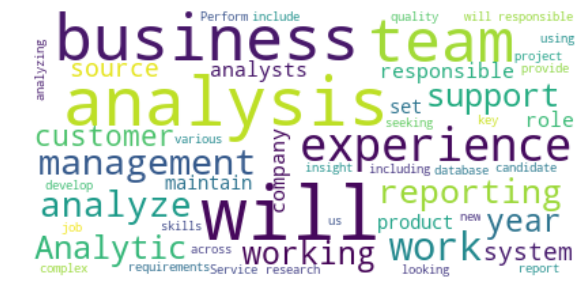

data+scientist


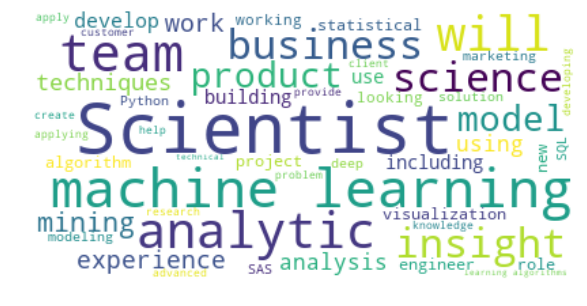

data+engineer


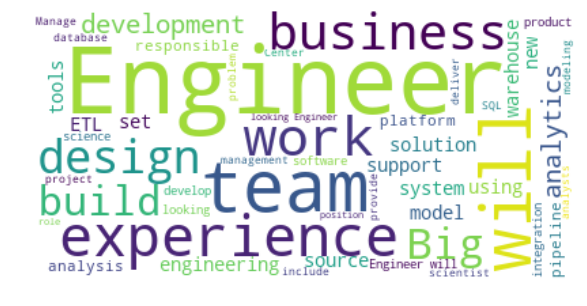

In [23]:
query_list = list(job_data.Query.unique())

for query in query_list:
    text = " ".join(synopsis for synopsis in job_data['Synopsis'].loc[job_data['Query']=='{}'.format(query)])
    print(str(query))
    wordcloud(text)

In [24]:
# Create keyword set with top words identified by LSA
keywords = set(topwords['LSA'].str.split(' ', 0).str[0])

# New dataframe with just the text and query
sentences = job_data[['Synopsis', 'Query']]

In [25]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['synopsis'] = sentences['Synopsis']
    df['query'] = sentences['Query']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['synopsis']):
        
        # Populate the row with word counts.
        for word in common_words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [26]:
word_counts = bow_features(sentences, keywords)
word_counts.head()

Processing row 0
Processing row 500


,including,science,algorithms,statistics,mysql,processing,statistical,knowledge,scientific,engineering,...,etl,use,scala,server,role,visualization,building,candidates,synopsis,query
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"The Data Analyst is responsible for the collection, analysis and reporting of client/customer data using complex analysis of datasets in areas of research,...",data+analyst
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,Proven work experience (preferably 2-3 years) as a data analyst or business data analyst. Job Posting – Data Analyst....,data+analyst
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Tradeweb has an opening for a Data Analyst within their Market Data group. Candidates should have strong technical skills related to data analysis, data...",data+analyst
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Web Data Analyst. Uline seeks a Web Data Analyst at its Corporate Headquarters in Pleasant Prairie, WI. Analyze data and provide weekly and monthly reports to...",data+analyst
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Perform data processing to manipulate the data to prepare for reporting including linking the data to other data sources, formatting the data, supplementing the...",data+analyst


In [27]:
Y = word_counts['query']
X = np.array(word_counts.drop(['synopsis','query'], 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [28]:
X = job_data['Synopsis']

# Set up parameters for the vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
# tokenize and build vocab
vectorizer.fit(X)

# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

# encode document
vector = vectorizer.transform([text[0]])

# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'analyst': 48, 'responsible': 829, 'collection': 164, 'analysis': 47, 'reporting': 815, 'client': 150, 'customer': 221, 'using': 1022, 'complex': 177, 'datasets': 228, 'areas': 72, 'research': 823, 'proven': 765, 'work': 1056, 'experience': 353, 'preferably': 728, 'years': 1065, 'business': 114, 'job': 525, 'tradeweb': 993, 'opening': 659, 'market': 590, 'group': 427, 'candidates': 121, 'strong': 943, 'technical': 977, 'skills': 898, 'related': 809, 'web': 1051, 'seeks': 877, 'corporate': 200, 'analyze': 53, 'provide': 766, 'weekly': 1053, 'monthly': 628, 'reports': 816, 'perform': 695, 'processing': 745, 'manipulate': 584, 'prepare': 730, 'including': 477, 'linking': 559, 'sources': 909, 'formatting': 402, 'supplementing': 955, 'provides': 769, 'clinical': 152, 'request': 818, 'general': 412, 'quantitative': 782, 'management': 580, 'visualization': 1040, 'junior': 529, 'closely': 154, 'operations': 662, 'sales': 853, 'executive': 348, 'teams': 975, 'proficient': 754, 'modeling': 623,


[6.12396398 6.41164605 5.90082043 ... 5.56434819 5.56434819 3.95491028]
(1, 1066)
[[0. 0. 0. ... 0. 0. 0.]]


# Clustering

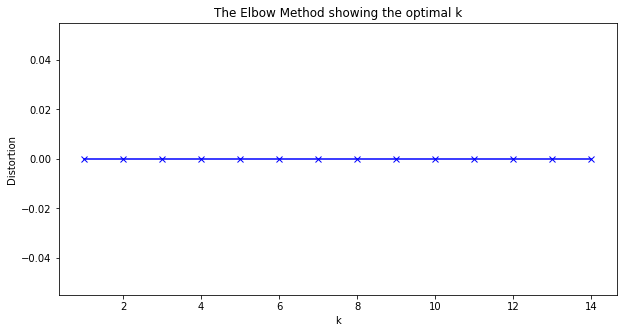

In [29]:
# Size of graph
plt.rcParams['figure.figsize'] = [10,5]

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
# Calulate predicted values
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=20)
y_pred0 = kmeans.fit_predict(X_train)

pd.crosstab(y_train, y_pred0)

col_0,0
query,
data+analyst,144
data+engineer,124
data+scientist,134


# Training the Model

### Random Forest

In [31]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

Random forest classifier score (without clustering): 0.35309(+/- 0.02)



### Logistic Regression

In [32]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (without clustering): {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_train_c = cross_val_score(lr, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (with clustering): {:.5f}(+/- {:.2f})'.format(lr_train_c.mean(), lr_train_c.std()*2))

NameError: name 'features' is not defined

### Gradient Boosting

In [ ]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_train_c = cross_val_score(gbc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(gbc_train_c.mean(), gbc_train_c.std()*2))